<a href="https://colab.research.google.com/github/mmcenta/le-net-beginner/blob/master/notebooks/torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

# Modern LeNet in PyTorch

This notebook is an implementation of the "Hello World" of ConvNets: the LeNet 5 architecture, evaluated on the MNIST dataset.

This is intended as a tool for beginners to get familiar with PyTorch as well as a training exercise for myself (very much a beginner to PyTorch as well).

This notebooks draws heavily from the PyTorch turorials in style and topic order.

Now that the introduction is out of the way, let's build our network!



## Load the data

Let's load the MNIST dataset from `torchvision`. We will also apply a
transformation pipeline that converts the images to tensors and normalizes them
to the [-1.0, 1.0] range.

First, we import the necessary modules and classes.

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

Then we load the train and dev sets into `DataLoaders`.

In [0]:
# Declare image transform pipeline
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))                               
])

# Load train set
train_set = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)

# Load dev set
dev_set = MNIST(root='./data', train=False, download=True, transform=transform)
dev_loader = DataLoader(dev_set, batch_size=64, shuffle=False, num_workers=2)

Let's see a random batch of images and their labels.

labels:
5 9 1 9 7 8 9 5
0 6 7 6 1 8 5 5
9 6 3 1 1 1 7 2
8 0 6 2 4 9 6 7
0 6 0 7 9 7 7 0
5 6 0 4 5 9 1 9
7 7 5 6 4 8 9 9
8 3 7 7 4 1 3 0


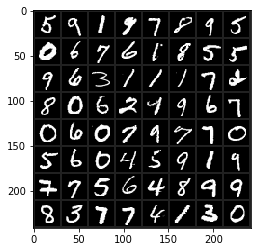

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Show an image
def show_image(img):
  img = 0.3081 * img + 0.1307     # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
show_image(torchvision.utils.make_grid(images))
# print labels
print('labels:\n'+'\n'.join(' '.join('%s' % labels[j].item() for j in range(8*i, 8*(i+1))) for i in range(8)))

## Define the model

Next we need to define the model we'll be using. We will be using a convolutional neural network deeply inspired on the classic LeNet architecture proposed in the "Gradient-based learning applied to document recognition" paper by LeCun et al.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class ModernLeNet(nn.Module):
  def __init__(self):
    super(ModernLeNet, self).__init__()
    
    # Convolutional layers
    self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
    self.maxpool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.maxpool2 = nn.MaxPool2d(2)

    # Fully connected layers
    self.fc1 = nn.Linear(16 * 5 * 5, 120) # unroll 5x5 image with 16 filters
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    # Convolutional part
    x = F.relu(self.conv1(x))
    x = self.maxpool1(x)
    x = F.relu(self.conv2(x))
    x = self.maxpool2(x)

    # Flatten the output volume
    n_batch = x.size()[0]
    x = x.view(n_batch, -1)

    # Fully connected part
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

model = ModernLeNet()

Before defining the loss function and the optimizer, transfer the model to the GPU if avaible.

In [6]:
# Get the device that will be used in training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Transfer the model to the correct device
model.to(device)

print(device)

cuda:0


We will use the cross entropy loss for this clasification task, as well as the Adam optimizer with default parameters.

In [0]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## Train the model

We will iterate over the training data for 100 epochs and print the loss each 5 epochs.

In [8]:
num_batches = int(len(train_set)/64 + 1)
losses = []

# Train for 30 epochs
for epoch in range(30):
  running_loss = 0.0

  for i, data in enumerate(train_loader, 0):
    # Get the inputs and transfer them to device
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    # Zero the gradients
    optimizer.zero_grad()

    # Train on this mini-batch
    outputs = model(inputs)           # forward pass
    loss = loss_fn(outputs, labels)   # calculate loss
    loss.backward()                   # backward pass
    optimizer.step()                  # update parameters

    # Update loss
    running_loss += loss.item()
    losses.append(loss.item())
  
  # Print the average loss for this epoch
  print('[epoch %d] loss: %.3f' % (epoch+1, running_loss/num_batches))
      
print('Finished Training')

[epoch 1] loss: 0.245
[epoch 2] loss: 0.066
[epoch 3] loss: 0.045
[epoch 4] loss: 0.036
[epoch 5] loss: 0.030
[epoch 6] loss: 0.025
[epoch 7] loss: 0.021
[epoch 8] loss: 0.018
[epoch 9] loss: 0.015
[epoch 10] loss: 0.013
[epoch 11] loss: 0.014
[epoch 12] loss: 0.011
[epoch 13] loss: 0.010
[epoch 14] loss: 0.009
[epoch 15] loss: 0.009
[epoch 16] loss: 0.010
[epoch 17] loss: 0.006
[epoch 18] loss: 0.007
[epoch 19] loss: 0.008
[epoch 20] loss: 0.006
[epoch 21] loss: 0.005
[epoch 22] loss: 0.009
[epoch 23] loss: 0.005
[epoch 24] loss: 0.006
[epoch 25] loss: 0.006
[epoch 26] loss: 0.006
[epoch 27] loss: 0.005
[epoch 28] loss: 0.004
[epoch 29] loss: 0.008
[epoch 30] loss: 0.004
Finished Training


Now let's print the evolution of the loss for each mini-batch:

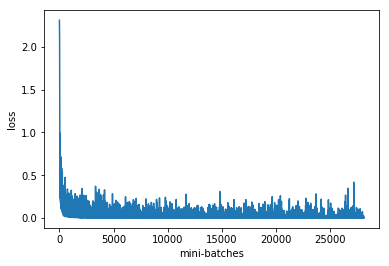

In [9]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('mini-batches')
plt.show()

Let's evaluate the accuracy of the model in the training set:

In [10]:
correct = 0
total = 0
with torch.no_grad():
  for data in train_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))

Accuracy of the network on the 10000 test images: 99 %


Not bad, but we are likely overfitting the training set.

## Evaluating the model

Now let's evaluate the model's performance on our dev set:

In [11]:
correct = 0
total = 0
with torch.no_grad():
  for data in dev_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


Just a little bit worse than the training set, but still way better than random! Let's print the confusion matrix to figure out where the network is making mistakes.

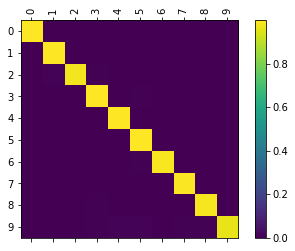

In [12]:
import matplotlib.ticker as ticker

# Calculate the confusion matrix on the dev set
def get_confusion_matrix():
  confusion = np.zeros((10, 10))

  # Count the mistakes made on the dev set
  with torch.no_grad():
    for data in dev_loader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs, 1)

      for i in range(labels.size(0)):
        confusion[labels[i]][predicted[i].item()] += 1.0

  # Normalize by dividing every row by its sum
  for i in range(10):
    confusion[i] = confusion[i] / confusion[i].sum()

  return confusion

def show_matrix(m):
  # Set up plot
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(confusion)
  fig.colorbar(cax)

  # Set up axes
  n = m.shape[0]
  ax.set_xticklabels([''] + [str(i) for i in range(n)], rotation=90)
  ax.set_yticklabels([''] + [str(i) for i in range(n)])

  # Force label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

confusion = get_confusion_matrix()
show_matrix(confusion)

Well, that wasn't very helpful. Let's try setting the diagonal to 0 and re-normalizing the rows so we can better analyse the mistakes.

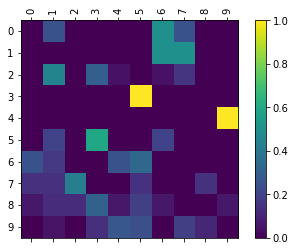

In [13]:
# Set the principal diagonal of the confusion matrix to 0 and re-normalize rows
for i in range(10):
  confusion[i][i] = 0.0
  confusion[i] = confusion[i] / confusion[i].sum()

# Display the matrix
show_matrix(confusion)


Keep in mind two things:
* The rows are the ground-truth and the columns are the guesses of the model.
* We have normalized the matrix by row, so a these values should analysed per row. More specifically, the model predicting 5's for 3's isn't necessarily the the most common mistake across all classes, but it is the most common mistake the model does when labeling 5's.

We see a couple of expected confusions: 0's with 6's, 3's with 5's, 3's with 8's, etc. These are hard for humans to distinguish sometimes. Let's see some examples of errors the model does. The following cell will find a mislabeled example and show it: 

actual: 3 - guess: 5
confidence in 5: 0.995
confidence in 3: 0.005


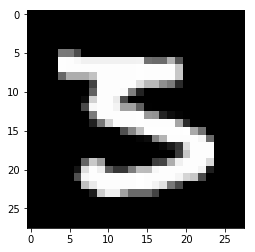

In [14]:
# Create a new shuffled loader so we get a different instance at each execution
dev_shuffle_loader = DataLoader(dev_set, batch_size=64, shuffle=True,
                                num_workers=2) 

with torch.no_grad():
  found = False

  for data in dev_shuffle_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    for i in range(labels.size(0)):
      if predicted[i] != labels[i]:
        found = True

        # Show image
        show_image(torchvision.utils.make_grid(images[i].cpu()))

        # Calculate confidence
        confidence = F.softmax(outputs[i], dim=0)

        # Print information about the mistake
        actual, guess = labels[i].item(), predicted[i].item()
        print('actual: %d - guess: %d' % (actual, guess))
        print('confidence in %d: %.3f' % (guess, confidence[guess].item()))
        print('confidence in %d: %.3f' % (actual, confidence[actual].item()))
        break
    
    if found:
      break

As we can see, a lot of the errors are on examples that are difficult even for humans to distinguish, so let's not be too critical :)

And that's it: we trained a small ConvNet to classify hand-written digits with good precision without much tuning. 

Next, you can check out the notebook that does implements this same model using TensorFlow and Keras. 

Thanks for reading this notebook!